# NanoGPT

My implementation of decoder only transformer based on Andrej Karpathy's model. This model generates Shakespeare-like text.

## Initialize

In [88]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl

In [2]:
# Set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data constants
DATASET_LINK='https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

In [4]:
# Set torch seed
torch.manual_seed(42)

## Dataset

### Load Dataset

In [5]:
# Download dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

--2024-06-15 21:33:11--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-06-15 21:33:11 (17.0 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [6]:
# Read dataset
raw_text = ''
with open('./input.txt','r') as f:
    raw_text = f.read()

In [7]:
# Data size
len(raw_text)

1115394

In [8]:
# Check data sample
print(raw_text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### Build Vocabulary

In [9]:
# Get unique characters
vocab = sorted(list(set(raw_text)))

In [10]:
# Get vocab size
vocab_size = len(vocab)

In [11]:
# Print vocab and vocab size
print(f'Vocab size:\n{vocab_size}')
print(f'Vocab list:\n{vocab}')

Vocab size:
65
Vocab list:
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:
# Create vocab mappings
token_to_i = {token:i for i,token in enumerate(vocab)}
i_to_token = {i:token for i,token in enumerate(vocab)}

In [13]:
# Encoder util
def encode(s):
    return [token_to_i[token] for token in s]

# Decoder util
def decode(s):
    return ''.join([i_to_token[token] for token in s])

In [14]:
# Test encoder and decoders
print(encode("Encoder and decoder test"))
print(decode(encode("Encoder and decoder test")))

[17, 52, 41, 53, 42, 43, 56, 1, 39, 52, 42, 1, 42, 43, 41, 53, 42, 43, 56, 1, 58, 43, 57, 58]
Encoder and decoder test


### Tokenize Dataset

In [15]:
# Tokenize data
tokenized_text = encode(raw_text)

In [16]:
# Convert data to tensor
data = torch.tensor(tokenized_text, dtype=torch.int64)

In [17]:
# Check data
print(data.shape)
print(data.dtype)
print(data[:100])

torch.Size([1115394])
torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


### Train Test Split

In [18]:
# Index for splitting
split_index = int(data.shape[0] * 0.8)

In [19]:
# Generate train and test data
train_data = data[:split_index]
test_data = data[split_index:]

In [20]:
# Print train/test sizes
print(train_data.shape)
print(test_data.shape)

torch.Size([892315])
torch.Size([223079])


### Data Batch Generator

In [21]:
# Utility to get batch
def _get_batch(split, batch_size, block_size):
    data_tensor = train_data if split == 'train' else test_data;
    block_indices = torch.randint(len(data_tensor) - block_size, (batch_size,))
    x = torch.stack([data_tensor[i:i+block_size] for i in block_indices])
    y = torch.stack([data_tensor[i+1:i+1+block_size] for i in block_indices])
    return x.to(device), y.to(device)

# Utility to get train batches
def get_train_batch(batch_size, block_size):
    return _get_batch('train', batch_size, block_size)

# Utility to get train batches
def get_test_batch(batch_size, block_size):
    return _get_batch('test', batch_size, block_size)    

In [22]:
# Test batch generator
_x, _y = get_train_batch(4,16)
print(_x.shape)
print(_y.shape)
print(_x)
print(_y)

torch.Size([4, 16])
torch.Size([4, 16])
tensor([[61, 47, 50, 50, 12,  0,  0, 28, 27, 24, 21, 36, 17, 26, 17, 31],
        [43,  1, 51, 47, 45, 46, 58,  1, 39, 41, 58,  1, 58, 46, 43,  1],
        [56,  1, 53, 44,  1, 58, 56, 47, 40, 59, 52, 43, 57,  1, 58, 46],
        [ 1, 39,  1, 58, 39, 50, 50,  1, 44, 43, 50, 50, 53, 61,  1, 53]],
       device='cuda:0')
tensor([[47, 50, 50, 12,  0,  0, 28, 27, 24, 21, 36, 17, 26, 17, 31, 10],
        [ 1, 51, 47, 45, 46, 58,  1, 39, 41, 58,  1, 58, 46, 43,  1, 61],
        [ 1, 53, 44,  1, 58, 56, 47, 40, 59, 52, 43, 57,  1, 58, 46, 39],
        [39,  1, 58, 39, 50, 50,  1, 44, 43, 50, 50, 53, 61,  1, 53, 44]],
       device='cuda:0')


## Transformer Model

#### Layer Norm

In [23]:
# Layer norm
class LayerNorm(nn.Module):

    # Constructor
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    # Call method
    def forward(self, x):
        x_mean = x.mean(1, keepdim=True)
        x_var = x.var(1, keepdim=True)
        out = (x - x_mean) / torch.sqrt(x_var + self.eps)
        out = self.gamma * out + self.beta
        self.out = out
        return self.out

Test layer norm

In [24]:
xt = torch.randn(16, 100)
ln = LayerNorm(100)
xt = ln(xt)
xt.shape

torch.Size([16, 100])

In [25]:
xt[0,:].mean(), xt[0,:].std()

(tensor(-2.0862e-09, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<StdBackward0>))

In [26]:
xt.std(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<StdBackward0>)

#### Multi-Head Attention

In [27]:
# Transformer head modue
class Head(nn.Module):

    # Constructor
    def __init__(self, block_size, n_embed, head_size, dropout):
        super().__init__()

        # Private properties
        self.head_size = head_size

        # K,Q,V layers
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)

        # Triangular matrix buffer
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # Dropout
        self.dropout = nn.Dropout(dropout)

    # Forward method
    def forward(self, x):

        # Get dims
        B,T,embed = x.shape

        # Calculate K,Q,V
        k = self.key(x) # (B,T,e) => (B,T,h)
        q = self.query(x) # (B,T,e) => (B,T,h)
        v = self.value(x) # (B,T,e) => (B,T,h)

        # Calculate self attention matrix
        attn = (q @ k.transpose(-2,-1)) * np.sqrt(self.head_size) # (B,T,h) @ (B,h,T) => (B,T,T)
        attn = attn.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B,T,T)
        attn = F.softmax(attn, dim=-1) # B,T,T
        attn = self.dropout(attn)

        # Aggregate values based on attention
        out = attn @ v
        return out

In [28]:
# Multi head attention module
class MultiHeadAttention(nn.Module):

    # Constructor
    def __init__(self, block_size, n_embed, n_heads, head_size, dropout):
        super().__init__()

        # Add multiple heads
        self.heads = [Head(block_size, n_embed, head_size, dropout).to(device) for _ in range(n_heads)]

        # Linear projection
        self.linear = nn.Linear(n_heads * head_size, n_embed)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    # Forward method
    def forward(self, x):

        # Concat results from all heads and return
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.linear(out))
        return out

#### Feed forward

In [29]:
# Feed forward block
class FeedForward(nn.Module):

    # Constructor
    def __init__(self, dim, dropout):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(dim, 4*dim),
            nn.ReLU(),
            nn.Linear(4*dim, dim),
            nn.Dropout(dropout)
        )

    # Forward method
    def forward(self, x):
        return self.nn(x)

#### Transformer Blocks

In [30]:
# Transformer's decoder block (No need of encoder block in GPT)
class DecoderBlock(nn.Module):

    # Constructor
    def __init__(self, block_size, n_embed, n_heads, dropout):
        super().__init__()
        head_size = n_embed // n_heads
        
        # Self attention and feed forward layers
        self.self_attn = MultiHeadAttention(block_size, n_embed, n_heads, head_size, dropout)
        self.ff = FeedForward(n_embed, dropout)

        # layer norm
        self.ln_1 = nn.LayerNorm(n_embed)
        self.ln_2 = nn.LayerNorm(n_embed)

    # Forward method
    def forward(self,x):
        x = x + self.self_attn(self.ln_1(x))
        x = x + self.ff(self.ln_2(x))
        return x

#### Transformer Model

In [31]:
# Transformer model class
class TransformerModel(nn.Module):

    # Constructor
    def __init__(self, block_size, n_embed, n_heads, n_layers, dropout):
        super().__init__()

        # Token embedding
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)

        # Positional embedding
        self.positional_embedding_table = nn.Embedding(block_size, n_embed)

        # Self attention layer
        self.blocks = nn.Sequential(*[DecoderBlock(block_size=block_size, n_embed=n_embed, n_heads=n_heads, dropout=dropout) for _ in range(n_layers)])
        self.ln = nn.LayerNorm(n_embed)
        
        # Linear layer
        self.lm_head = nn.Linear(n_embed, vocab_size)

    # Forward method
    def forward(self, x, targets=None):
    
        # x is (B,T) and targets is also (B,T)
        B,T = x.shape

        # Apply token and positional embeddings
        tok_embedding = self.token_embedding_table(x) # embeddings will be (B,T,n_embed)
        pos_embedding = self.positional_embedding_table(torch.arange(T, device=device)) # embeddings will be (T,n_embed)
        x = tok_embedding + pos_embedding # (B,T,n_embed)
        
        # Apply decoder blocks and layer norm
        x = self.blocks(x) # (B,T,n_embed)
        x = self.ln(x) # (B,T,n_embed)

        # Get logits
        logits = self.lm_head(x) # logits will be (B,T,vocab_size)

        # Get loss
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        # Return
        return logits, loss

    # Generate method to generate next tokens
    def generate(self, x, max_tokens):

        # Loop and generate tokens
        for _ in range(max_tokens):

            # Get last block
            last_block = x[:,-block_size:]

            # Get predictions
            logits, loss = self(last_block) # logits: (B,T,vocab_size)

            # Get generated token and append to x
            logits = logits[:,-1,:] # (B,vocab_size)
            probs = F.softmax(logits, dim=-1) # (B,vocab_size)
            next_token = torch.multinomial(probs, num_samples=1) # (B,1)
            x = torch.cat((x, next_token), dim=1) # (B,T+1)

        # Return generated text
        return x

Experiments

In [32]:
model = TransformerModel(
    n_embed = 256,
    block_size = 256,
    n_heads = 8,
    n_layers = 8,
    dropout=0.2
)
model.to(device)
logits, loss = model(_x.to(device),_y.to(device))
print(logits.shape)

torch.Size([64, 65])


## Training

#### Training Utils

In [33]:
# Constants
eval_iters = 100

In [34]:
# Function to estimate loss based on random batches
@torch.no_grad()
def estimate_loss(m, batch_size, block_size):
    out = {}
    model.eval()
    train_losses = torch.zeros(eval_iters)
    val_losses = torch.zeros(eval_iters)
    for i in range(eval_iters):
        x, y = get_train_batch(batch_size, block_size)
        logits, loss = m(x, y)
        train_losses[i] = loss.item()
        x, y = get_test_batch(batch_size, block_size)
        logits, loss = m(x, y)
        val_losses[i] = loss.item()
    return train_losses.mean(), val_losses.mean()

In [57]:
# Training loop
def train(model, max_steps, eval_interval, loss_list, init_step=0):
    model.train()

    # Loop steps
    for step in range(max_steps):
    
        # Get sample batch
        x, y = get_train_batch(batch_size, block_size)
    
        # Evaluate
        logits, loss = model(x.to(device),y.to(device))
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
        # Estimate and print loss
        if(step == 0 or (step + 1) % eval_interval == 0 or step == max_steps - 1):
            train_loss, val_loss = estimate_loss(model, batch_size, block_size)
            loss_list.append({
                'step': init_step+step,
                'train_loss': train_loss,
                'val_loss': val_loss
            })
            print(f'Step {init_step+step+1:<4}: train loss [{train_loss:.4f}], val loss:[{val_loss:.4f}] ')

#### Training Setup

In [36]:
# Model params
batch_size = 64
block_size = 256
learning_rate = 5e-4
embedding_dim = 256
num_heads = 8
num_layers = 6
dropout = 0.2

In [58]:
# Model
model = TransformerModel(
    n_embed = embedding_dim,
    block_size = block_size,
    n_heads = num_heads,
    n_layers = num_layers,
    dropout=dropout
)
model.to(device)

TransformerModel(
  (token_embedding_table): Embedding(65, 256)
  (positional_embedding_table): Embedding(256, 256)
  (blocks): Sequential(
    (0): DecoderBlock(
      (self_attn): MultiHeadAttention(
        (linear): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (nn): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): DecoderBlock(
      (self_attn): MultiHeadAttention(
        (linear): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (nn): Sequential(
          (0)

In [59]:
# Training params
eval_iters = 100
eval_interval = 100
learning_rate = 2e-4

In [60]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

#### Training

In [62]:
# Loss data
loss_data = []

In [63]:
# Train 5000 steps
train(model=model, max_steps=5000, eval_interval=eval_interval, loss_list=loss_data, init_step=0)

Step 1   : train loss [4.0304], val loss:[4.0382] 
Step 100 : train loss [2.5627], val loss:[2.5893] 
Step 200 : train loss [2.4965], val loss:[2.5333] 
Step 300 : train loss [2.4738], val loss:[2.5147] 
Step 400 : train loss [2.4607], val loss:[2.5000] 
Step 500 : train loss [2.4537], val loss:[2.4966] 
Step 600 : train loss [2.4439], val loss:[2.4900] 
Step 700 : train loss [2.4333], val loss:[2.4828] 
Step 800 : train loss [2.4194], val loss:[2.4739] 
Step 900 : train loss [2.4051], val loss:[2.4602] 
Step 1000: train loss [2.3843], val loss:[2.4393] 
Step 1100: train loss [2.3630], val loss:[2.4241] 
Step 1200: train loss [2.3323], val loss:[2.4024] 
Step 1300: train loss [2.2941], val loss:[2.3667] 
Step 1400: train loss [2.2572], val loss:[2.3352] 
Step 1500: train loss [2.2225], val loss:[2.3089] 
Step 1600: train loss [2.1725], val loss:[2.2639] 
Step 1700: train loss [2.1313], val loss:[2.2224] 
Step 1800: train loss [2.0986], val loss:[2.2023] 
Step 1900: train loss [2.0708],

In [76]:
# Save checkpoint
torch.save(model, './model_5k_steps_2e-4_lr.pt')

In [79]:
# Train 2500 more steps (Total 7500)
train(model=model, max_steps=2500, eval_interval=eval_interval, loss_list=loss_data, init_step=5000)

Step 5001: train loss [1.6677], val loss:[1.9133] 
Step 5100: train loss [1.5792], val loss:[1.8192] 
Step 5200: train loss [1.5640], val loss:[1.7979] 
Step 5300: train loss [1.5558], val loss:[1.8005] 
Step 5400: train loss [1.5497], val loss:[1.7934] 
Step 5500: train loss [1.5454], val loss:[1.7962] 
Step 5600: train loss [1.5339], val loss:[1.7881] 
Step 5700: train loss [1.5330], val loss:[1.7873] 
Step 5800: train loss [1.5232], val loss:[1.7907] 
Step 5900: train loss [1.5176], val loss:[1.7812] 
Step 6000: train loss [1.5073], val loss:[1.7846] 
Step 6100: train loss [1.5068], val loss:[1.7680] 
Step 6200: train loss [1.5026], val loss:[1.7774] 
Step 6300: train loss [1.5003], val loss:[1.7631] 
Step 6400: train loss [1.4895], val loss:[1.7587] 
Step 6500: train loss [1.4891], val loss:[1.7629] 
Step 6600: train loss [1.4836], val loss:[1.7568] 
Step 6700: train loss [1.4777], val loss:[1.7575] 
Step 6800: train loss [1.4738], val loss:[1.7501] 
Step 6900: train loss [1.4658],

In [80]:
# Save checkpoint
torch.save(model, './model_7.5k_steps_2e-4_lr.pt')

In [82]:
# Train 2500 more steps (Total 10000)
train(model=model, max_steps=2500, eval_interval=eval_interval, loss_list=loss_data, init_step=7500)

Step 7501: train loss [1.5079], val loss:[1.7998] 
Step 7600: train loss [1.4361], val loss:[1.7311] 
Step 7700: train loss [1.4310], val loss:[1.7314] 
Step 7800: train loss [1.4293], val loss:[1.7296] 
Step 7900: train loss [1.4305], val loss:[1.7300] 
Step 8000: train loss [1.4224], val loss:[1.7230] 
Step 8100: train loss [1.4132], val loss:[1.7253] 
Step 8200: train loss [1.4157], val loss:[1.7260] 
Step 8300: train loss [1.4102], val loss:[1.7159] 
Step 8400: train loss [1.4099], val loss:[1.7244] 
Step 8500: train loss [1.4072], val loss:[1.7209] 
Step 8600: train loss [1.4039], val loss:[1.7174] 
Step 8700: train loss [1.3998], val loss:[1.7177] 
Step 8800: train loss [1.3954], val loss:[1.7157] 
Step 8900: train loss [1.3955], val loss:[1.7116] 
Step 9000: train loss [1.3910], val loss:[1.7197] 
Step 9100: train loss [1.3888], val loss:[1.7153] 
Step 9200: train loss [1.3783], val loss:[1.7092] 
Step 9300: train loss [1.3820], val loss:[1.7104] 
Step 9400: train loss [1.3762],

In [83]:
# Save checkpoint
torch.save(model, './model_10k_steps_2e-4_lr.pt')

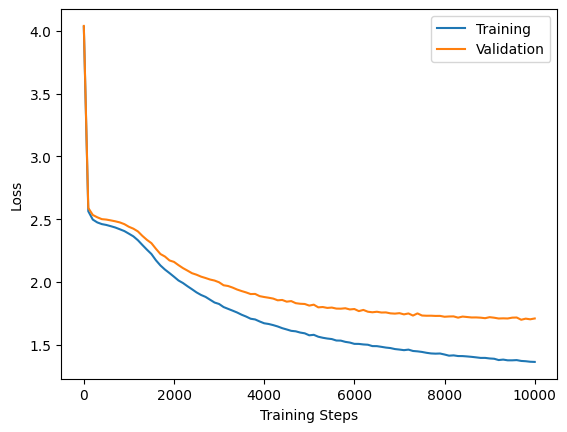

In [115]:
# Plot losses
df = pd.DataFrame(loss_data)
df = df.drop([df[df.step == 7500].index[0], df[df.step == 5000].index[0]]) # Drop the first record on resuming, else we will have 5000 and 5001 both
plt.plot(df['step'], df['train_loss'])
plt.plot(df['step'], df['val_loss'])
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

In [89]:
# Save loss data
with open('losses.pkl','wb') as f:
    pkl.dump(loss_data, f)

In [116]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 1000)
print(decode(gen[0].tolist()))


Wouldst he fair of in this laster'd birds,--

PRIStETER:
Thou knows town the trumphants one served
What I make at about reptience in on queen;
Shall light in once needs though the herebs,
Could be confort thee: bry with me fin all walf,
Take thou, ere we grant down thee hents,
And bid Ithe the cause enjorn taken tee
hore place they some of the wronch; when left angue,
But weep the freely to city charge:
There Clifford's speed, alas, and becomend severight,
Which this by mine a three to the worst.

VALET:
Alack, lord.

BUCKINGHAM:
Then busines down?
Mark thou shad for the pirace,
The feary operfice I see at will slend
And the senate, go is that a condauses
in that Maristake thee come to my queen!

KING RICHARD II:
Who young foranot you and may me now we in merry,
Upon the guard instatily: bear livs hee, me lets
To hath been and onceivil age and the sabsed owe bird,
Who can all them before as hour, return, pity were to me
His sile kindly father 'Doles and the vown:
And news shall quarre

In [117]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 1000)
print(decode(gen[0].tolist()))


And will my rasy; condem'd lie thee sensite
Of promperying look upon upon.
Helpinage good to the graftere;

GLOUCESTER:
None consin in, or let to justic it your day
When they are asleep-wachmen his poor
Burging a king: when here it is a the tides
Would drink to the point, next with thy state:
And be seen your we both 'gainst your wates; rather all
And more no with the life that daught from my lord.

KING HENRY VITHORK:
It not the ciupand's each off miish?

DUKESS OF YORK:
And what thou never sadom?

VOLUMNIA:
Too.

YORK:
AI will so the such of not or speedishy soul!

Citizens:
If thee to not leave them I bury, and his like,
To this cricks from drops with not be reful die.

DUCHESS OF YORK:
Honow I would yea, here consul find notel.

KING HENRY VI

GLOUCESTER:
What now you are these with days, ere this
but on the busines and the ose unto him,
Than an thee misjoy tended, servey your horse.

Servant:
It is, all summuch bove a loss in again,
Smew let their to gatest, been with her like,
T

#### Test Generations

These are generation tests at different points during dev

In [133]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 100)
print(gen.shape)
print(decode(gen[0].tolist()))

torch.Size([1, 101])

Reacou'gr te thand tibary fachary aCafh't thaifu Casnoumt mldyou I cance-snOe allatry, M: owin fi ur


In [50]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 100)
print(gen.shape)
print(decode(gen[0].tolist()))

torch.Size([1, 101])

co y ind deiced tlat manginsigesps
Selthangean th url sat ghe mt machan tHe.
e
N dFind wisthurore ce


In [84]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 100)
print(gen.shape)
print(decode(gen[0].tolist()))

torch.Size([1, 101])

QUSTEGSUK:
HakNy Ebd I theollds:
Do with syounty ther whath crist bUllnginy tard.


QUCUEESHERY Lom;


In [126]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 100)
print(decode(gen[0].tolist()))


Ho ting My I:
ward god have kis,
Wow,
Hrerit, worsth
Thing luor heng tholeil mecow hund End.
CENLIAS


In [112]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 200)
print(decode(gen[0].tolist()))


gidine were my har death the consins
Romeon these would play dest with their friend.

Serdard:
Why; Wenry have happing, make in deed the was
That youth, dowy in beg list hime -havous tialte,
To some h


In [154]:
# Test generation
gen = model.generate(torch.zeros((1,1), dtype=torch.long, device=device), 200)
print(decode(gen[0].tolist()))


And they see met, to bring the life; I
And with stand way.

MERCUTIO:
Two of the good! this dost me; your lord bed,
For all wait to hear, answer than hand,
But when raster woulds the way we who weep?

